# Mastercard Pipeline Analytics
## Identity Revenue Operations - Quarterly Business Review Analysis

This notebook performs end-to-end analysis of commercial pipeline data, including:
- Data cleaning and transformation
- Pipeline health KPIs
- Revenue forecasting metrics
- Performance analysis by owner, region, and time
- Visualizations and QBR-ready insights


## 1. Setup & Imports


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')

# Set visualization style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 10

# Display options
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)
pd.set_option('display.float_format', lambda x: '%.2f' % x)

print("Libraries imported successfully!")
print(f"Analysis date: {datetime.now().strftime('%Y-%m-%d')}")


Libraries imported successfully!
Analysis date: 2025-11-23


## 2. Data Loading & Initial Exploration


In [4]:
# Load the dataset
df = pd.read_csv('mastercard_pipeline_dataset.csv')

print("=" * 60)
print("DATASET OVERVIEW")
print("=" * 60)
print(f"Shape: {df.shape[0]} rows  {df.shape[1]} columns")
print(f"\nColumn names: {list(df.columns)}")
print(f"\nData types:\n{df.dtypes}")
print(f"\nFirst few rows:")
df.head()


DATASET OVERVIEW
Shape: 500 rows  9 columns

Column names: ['opportunity_id', 'owner', 'region', 'deal_value', 'stage', 'days_in_stage', 'probability', 'created_date', 'expected_close_date']

Data types:
opportunity_id          object
owner                   object
region                  object
deal_value             float64
stage                   object
days_in_stage            int64
probability            float64
created_date            object
expected_close_date     object
dtype: object

First few rows:


,opportunity_id,owner,region,deal_value,stage,days_in_stage,probability,created_date,expected_close_date
0,OPP-1000,D. Johnson,West,233368.98,Prospecting,43,0.40,2025-06-21,2025-08-08
1,OPP-1001,E. Rivera,Northeast,143457.63,Prospecting,1,0.31,2025-05-29,2025-09-06
2,OPP-1002,C. Patel,International,175679.45,Proposal,45,0.52,2025-01-28,2025-08-02
3,OPP-1003,E. Rivera,Midwest,231012.35,Negotiation,51,0.82,2025-02-23,2025-07-13
4,OPP-1004,E. Rivera,Midwest,178273.47,Prospecting,24,0.56,2025-03-06,2025-09-22


In [5]:
# Basic statistics and data quality check
print("=" * 60)
print("DATA QUALITY CHECK")
print("=" * 60)
print(f"\nMissing values:\n{df.isnull().sum()}")
print(f"\nDuplicate opportunities: {df['opportunity_id'].duplicated().sum()}")
print(f"\nSummary statistics:")
df.describe()


DATA QUALITY CHECK

Missing values:
opportunity_id         0
owner                  0
region                 0
deal_value             0
stage                  0
days_in_stage          0
probability            0
created_date           0
expected_close_date    0
dtype: int64

Duplicate opportunities: 0

Summary statistics:


,deal_value,days_in_stage,probability
count,500.00,500.00,500.00
mean,127085.65,30.68,0.51
std,72537.92,16.86,0.19
min,6134.85,1.00,0.05
25%,61588.52,17.00,0.38
50%,126854.92,30.50,0.50
75%,190943.58,46.00,0.63
max,249493.86,59.00,0.95


In [6]:
# Check unique values for categorical columns
print("=" * 60)
print("CATEGORICAL VARIABLES")
print("=" * 60)
print(f"\nUnique stages: {sorted(df['stage'].unique())}")
print(f"\nUnique regions: {sorted(df['region'].unique())}")
print(f"\nUnique owners: {sorted(df['owner'].unique())}")
print(f"\nStage distribution:\n{df['stage'].value_counts()}")
print(f"\nRegion distribution:\n{df['region'].value_counts()}")
print(f"\nOwner distribution:\n{df['owner'].value_counts()}")


CATEGORICAL VARIABLES

Unique stages: ['Closed Lost', 'Closed Won', 'Negotiation', 'Proposal', 'Prospecting', 'Qualified']

Unique regions: ['International', 'Midwest', 'Northeast', 'Southeast', 'West']

Unique owners: ['A. Smith', 'B. Chen', 'C. Patel', 'D. Johnson', 'E. Rivera']

Stage distribution:
stage
Prospecting    131
Proposal       104
Qualified       86
Negotiation     77
Closed Won      53
Closed Lost     49
Name: count, dtype: int64

Region distribution:
region
International    111
Northeast        101
Midwest           99
Southeast         95
West              94
Name: count, dtype: int64

Owner distribution:
owner
D. Johnson    112
A. Smith      109
B. Chen        95
E. Rivera      93
C. Patel       91
Name: count, dtype: int64


## 3. Data Cleaning & Transformation


In [7]:
# Create a copy for cleaning
df_clean = df.copy()

# Convert date columns to datetime
df_clean['created_date'] = pd.to_datetime(df_clean['created_date'])
df_clean['expected_close_date'] = pd.to_datetime(df_clean['expected_close_date'])

# Ensure numeric columns are properly typed
df_clean['deal_value'] = pd.to_numeric(df_clean['deal_value'], errors='coerce')
df_clean['days_in_stage'] = pd.to_numeric(df_clean['days_in_stage'], errors='coerce')
df_clean['probability'] = pd.to_numeric(df_clean['probability'], errors='coerce')

print("Date and numeric columns converted successfully!")
print(f"\nData types after conversion:\n{df_clean.dtypes}")


Date and numeric columns converted successfully!

Data types after conversion:
opportunity_id                 object
owner                          object
region                         object
deal_value                    float64
stage                          object
days_in_stage                   int64
probability                   float64
created_date           datetime64[ns]
expected_close_date    datetime64[ns]
dtype: object


In [8]:
# Data validation
print("=" * 60)
print("DATA VALIDATION")
print("=" * 60)

# Check probability range
prob_out_of_range = df_clean[(df_clean['probability'] < 0) | (df_clean['probability'] > 1)]
print(f"Probabilities out of range (0-1): {len(prob_out_of_range)}")

# Check for negative deal values
negative_deals = df_clean[df_clean['deal_value'] < 0]
print(f"Negative deal values: {len(negative_deals)}")

# Check for deals with expected_close_date in the past
today = datetime.now().date()
past_close_dates = df_clean[df_clean['expected_close_date'].dt.date < today]
print(f"Deals with expected_close_date in the past: {len(past_close_dates)}")

# Validate stage names
expected_stages = ['Prospecting', 'Qualified', 'Proposal', 'Negotiation', 'Closed Won', 'Closed Lost']
invalid_stages = df_clean[~df_clean['stage'].isin(expected_stages)]
print(f"Invalid stage names: {len(invalid_stages)}")

if len(invalid_stages) > 0:
    print(f"Invalid stages found: {invalid_stages['stage'].unique()}")


DATA VALIDATION
Probabilities out of range (0-1): 0
Negative deal values: 0
Deals with expected_close_date in the past: 500
Invalid stage names: 0


In [9]:
# Calculate derived fields
today = datetime.now().date()

# Weighted pipeline (deal_value  probability)
df_clean['weighted_pipeline'] = df_clean['deal_value'] * df_clean['probability']

# Days to close (expected_close_date - today)
df_clean['days_to_close'] = (df_clean['expected_close_date'].dt.date - today).apply(lambda x: x.days if pd.notnull(x) else None)

# Pipeline age (today - created_date)
df_clean['pipeline_age'] = (today - df_clean['created_date'].dt.date).apply(lambda x: x.days if pd.notnull(x) else None)

# Flag at-risk deals
df_clean['is_overdue'] = df_clean['expected_close_date'].dt.date < today
df_clean['is_stuck'] = df_clean['days_in_stage'] > 60
df_clean['at_risk'] = df_clean['is_overdue'] | df_clean['is_stuck']

# Add quarter/year fields for time-based analysis
df_clean['created_quarter'] = df_clean['created_date'].dt.to_period('Q')
df_clean['expected_close_quarter'] = df_clean['expected_close_date'].dt.to_period('Q')
df_clean['created_year'] = df_clean['created_date'].dt.year
df_clean['expected_close_year'] = df_clean['expected_close_date'].dt.year

print("Derived fields calculated successfully!")
print(f"\nSample of cleaned data with new fields:")
df_clean[['opportunity_id', 'deal_value', 'probability', 'weighted_pipeline',
          'days_to_close', 'pipeline_age', 'at_risk']].head(10)


Derived fields calculated successfully!

Sample of cleaned data with new fields:


,opportunity_id,deal_value,probability,weighted_pipeline,days_to_close,pipeline_age,at_risk
0,OPP-1000,233368.98,0.40,93347.59,-107,155,True
1,OPP-1001,143457.63,0.31,44471.87,-78,178,True
2,OPP-1002,175679.45,0.52,91353.31,-113,299,True
3,OPP-1003,231012.35,0.82,189430.13,-133,273,True
4,OPP-1004,178273.47,0.56,99833.14,-62,262,True
5,OPP-1005,42372.07,0.45,19067.43,-92,227,True
6,OPP-1006,146190.65,0.44,64323.89,-139,306,True
7,OPP-1007,153645.19,0.19,29192.59,-67,314,True
8,OPP-1008,108912.01,0.68,74060.17,-59,270,True
9,OPP-1009,185428.84,0.48,89005.84,-132,278,True


## 4. Pipeline Health KPIs


In [10]:
# Filter active opportunities (exclude Closed Won and Closed Lost)
active_df = df_clean[~df_clean['stage'].isin(['Closed Won', 'Closed Lost'])]

print("=" * 60)
print("PIPELINE HEALTH KPIs")
print("=" * 60)

# Total Pipeline Metrics
total_pipeline_value = active_df['deal_value'].sum()
total_weighted_pipeline = active_df['weighted_pipeline'].sum()
active_opportunities_count = len(active_df)

print(f"\n TOTAL PIPELINE METRICS")
print(f"Total Pipeline Value: ${total_pipeline_value:,.2f}")
print(f"Weighted Pipeline: ${total_weighted_pipeline:,.2f}")
print(f"Active Opportunities: {active_opportunities_count}")

# Calculate pipeline coverage ratio
print(f"\nPipeline Coverage Ratio: {total_weighted_pipeline/total_pipeline_value:.2%}")


PIPELINE HEALTH KPIs

 TOTAL PIPELINE METRICS
Total Pipeline Value: $50,653,505.20
Weighted Pipeline: $25,622,115.65
Active Opportunities: 398

Pipeline Coverage Ratio: 50.58%


In [11]:
# Stage Distribution
stage_order = ['Prospecting', 'Qualified', 'Proposal', 'Negotiation', 'Closed Won', 'Closed Lost']

stage_metrics = df_clean.groupby('stage').agg({
    'deal_value': ['sum', 'count', 'mean'],
    'weighted_pipeline': 'sum',
    'days_in_stage': 'mean',
    'probability': 'mean'
}).round(2)

stage_metrics.columns = ['Total_Value', 'Count', 'Avg_Deal_Size', 'Weighted_Pipeline', 'Avg_Days_in_Stage', 'Avg_Probability']
stage_metrics = stage_metrics.reindex([s for s in stage_order if s in stage_metrics.index])

print("\n STAGE DISTRIBUTION")
print(stage_metrics)



 STAGE DISTRIBUTION
             Total_Value  Count  Avg_Deal_Size  Weighted_Pipeline  \
stage                                                               
Prospecting  16979163.97    131      129611.94         8703632.94   
Qualified    10946972.73     86      127290.38         5546841.78   
Proposal     12466008.02    104      119865.46         6480538.45   
Negotiation  10261360.48     77      133264.42         4891102.48   
Closed Won    7145462.65     53      134820.05         3783857.96   
Closed Lost   5743856.24     49      117221.56         3050822.92   

             Avg_Days_in_Stage  Avg_Probability  
stage                                            
Prospecting              34.00             0.51  
Qualified                29.83             0.48  
Proposal                 29.64             0.50  
Negotiation              31.45             0.49  
Closed Won               28.81             0.52  
Closed Lost              26.33             0.55  


In [12]:
# Conversion Metrics
closed_won = len(df_clean[df_clean['stage'] == 'Closed Won'])
closed_lost = len(df_clean[df_clean['stage'] == 'Closed Lost'])
total_closed = closed_won + closed_lost

win_rate = closed_won / total_closed if total_closed > 0 else 0
loss_rate = closed_lost / total_closed if total_closed > 0 else 0

# Stage-to-stage conversion (simplified - would need historical data for true conversion)
# For now, calculate based on current distribution
stage_counts = df_clean['stage'].value_counts()
prospecting_count = stage_counts.get('Prospecting', 0)
qualified_count = stage_counts.get('Qualified', 0)
proposal_count = stage_counts.get('Proposal', 0)
negotiation_count = stage_counts.get('Negotiation', 0)

print("\n CONVERSION METRICS")
print(f"Overall Win Rate: {win_rate:.2%}")
print(f"Overall Loss Rate: {loss_rate:.2%}")
print(f"\nStage Distribution (for conversion analysis):")
print(f"Prospecting  Qualified: {prospecting_count} opportunities")
print(f"Qualified  Proposal: {qualified_count} opportunities")
print(f"Proposal  Negotiation: {proposal_count} opportunities")
print(f"Negotiation  Closed: {negotiation_count} opportunities")



 CONVERSION METRICS
Overall Win Rate: 51.96%
Overall Loss Rate: 48.04%

Stage Distribution (for conversion analysis):
Prospecting  Qualified: 131 opportunities
Qualified  Proposal: 86 opportunities
Proposal  Negotiation: 104 opportunities
Negotiation  Closed: 77 opportunities


In [13]:
# Velocity Metrics
velocity_metrics = df_clean.groupby('stage').agg({
    'days_in_stage': 'mean',
    'pipeline_age': 'mean',
    'days_to_close': 'mean'
}).round(1)

print("\n VELOCITY METRICS")
print("Average days in each stage:")
print(velocity_metrics[['days_in_stage']].dropna())

overall_avg_pipeline_age = df_clean['pipeline_age'].mean()
overall_avg_days_to_close = active_df['days_to_close'].mean()

print(f"\nOverall Average Pipeline Age: {overall_avg_pipeline_age:.1f} days")
print(f"Overall Average Days to Close: {overall_avg_days_to_close:.1f} days")



 VELOCITY METRICS
Average days in each stage:
             days_in_stage
stage                     
Closed Lost          26.30
Closed Won           28.80
Negotiation          31.50
Proposal             29.60
Prospecting          34.00
Qualified            29.80

Overall Average Pipeline Age: 236.3 days
Overall Average Days to Close: -99.9 days


In [14]:
# Aging Analysis
aging_30 = active_df[active_df['days_in_stage'] > 30]
aging_60 = active_df[active_df['days_in_stage'] > 60]
aging_90 = active_df[active_df['days_in_stage'] > 90]

print("\n AGING ANALYSIS")
print(f"Deals stuck in stage >30 days: {len(aging_30)} (${aging_30['deal_value'].sum():,.2f})")
print(f"Deals stuck in stage >60 days: {len(aging_60)} (${aging_60['deal_value'].sum():,.2f})")
print(f"Deals stuck in stage >90 days: {len(aging_90)} (${aging_90['deal_value'].sum():,.2f})")

print(f"\nAt-risk deals (overdue or stuck): {active_df['at_risk'].sum()}")
print(f"At-risk deal value: ${active_df[active_df['at_risk']]['deal_value'].sum():,.2f}")



 AGING ANALYSIS
Deals stuck in stage >30 days: 207 ($26,980,184.51)
Deals stuck in stage >60 days: 0 ($0.00)
Deals stuck in stage >90 days: 0 ($0.00)

At-risk deals (overdue or stuck): 398
At-risk deal value: $50,653,505.20


## 5. Revenue Forecasting KPIs


In [15]:
# Forecast by Stage
forecast_by_stage = active_df.groupby('stage').agg({
    'weighted_pipeline': 'sum',
    'deal_value': 'sum',
    'opportunity_id': 'count'
}).round(2)
forecast_by_stage.columns = ['Weighted_Forecast', 'Total_Value', 'Count']
forecast_by_stage = forecast_by_stage.reindex([s for s in stage_order if s in forecast_by_stage.index])

print("=" * 60)
print("REVENUE FORECASTING KPIs")
print("=" * 60)
print("\n FORECAST BY STAGE")
print(forecast_by_stage)


REVENUE FORECASTING KPIs

 FORECAST BY STAGE
             Weighted_Forecast  Total_Value  Count
stage                                             
Prospecting         8703632.94  16979163.97    131
Qualified           5546841.78  10946972.73     86
Proposal            6480538.45  12466008.02    104
Negotiation         4891102.48  10261360.48     77


In [16]:
# Forecast by Expected Close Quarter
forecast_by_quarter = active_df.groupby('expected_close_quarter').agg({
    'weighted_pipeline': 'sum',
    'deal_value': 'sum',
    'opportunity_id': 'count'
}).round(2)
forecast_by_quarter.columns = ['Weighted_Forecast', 'Total_Value', 'Count']
forecast_by_quarter = forecast_by_quarter.sort_index()

print("\n FORECAST BY EXPECTED CLOSE QUARTER")
print(forecast_by_quarter)



 FORECAST BY EXPECTED CLOSE QUARTER
                        Weighted_Forecast  Total_Value  Count
expected_close_quarter                                       
2025Q3                        25622115.65  50653505.20    398


In [17]:
# Forecast Accuracy (comparing Closed Won deals vs their original probability-weighted forecast)
closed_won_deals = df_clean[df_clean['stage'] == 'Closed Won']
if len(closed_won_deals) > 0:
    actual_revenue = closed_won_deals['deal_value'].sum()
    forecasted_revenue = closed_won_deals['weighted_pipeline'].sum()

    forecast_accuracy = (forecasted_revenue / actual_revenue) if actual_revenue > 0 else 0
    forecast_error = actual_revenue - forecasted_revenue

    print("\n FORECAST ACCURACY (Closed Won Deals)")
    print(f"Actual Revenue: ${actual_revenue:,.2f}")
    print(f"Forecasted Revenue (weighted): ${forecasted_revenue:,.2f}")
    print(f"Forecast Accuracy Ratio: {forecast_accuracy:.2%}")
    print(f"Forecast Error: ${forecast_error:,.2f}")
else:
    print("\n No closed won deals available for forecast accuracy analysis")



 FORECAST ACCURACY (Closed Won Deals)
Actual Revenue: $7,145,462.65
Forecasted Revenue (weighted): $3,783,857.96
Forecast Accuracy Ratio: 52.95%
Forecast Error: $3,361,604.69


In [18]:
# Commit vs Forecast Breakdown
commit_deals = active_df[active_df['probability'] > 0.7]
best_case_deals = active_df[(active_df['probability'] >= 0.4) & (active_df['probability'] <= 0.7)]
upside_deals = active_df[active_df['probability'] < 0.4]

commit_forecast = commit_deals['weighted_pipeline'].sum()
best_case_forecast = best_case_deals['weighted_pipeline'].sum()
upside_forecast = upside_deals['weighted_pipeline'].sum()

commit_value = commit_deals['deal_value'].sum()
best_case_value = best_case_deals['deal_value'].sum()
upside_value = upside_deals['deal_value'].sum()

print("\n COMMIT VS FORECAST BREAKDOWN")
print(f"\nCOMMIT (Probability > 70%):")
print(f"  Deal Count: {len(commit_deals)}")
print(f"  Total Value: ${commit_value:,.2f}")
print(f"  Weighted Forecast: ${commit_forecast:,.2f}")

print(f"\nBEST CASE (Probability 40-70%):")
print(f"  Deal Count: {len(best_case_deals)}")
print(f"  Total Value: ${best_case_value:,.2f}")
print(f"  Weighted Forecast: ${best_case_forecast:,.2f}")

print(f"\nUPSIDE (Probability < 40%):")
print(f"  Deal Count: {len(upside_deals)}")
print(f"  Total Value: ${upside_value:,.2f}")
print(f"  Weighted Forecast: ${upside_forecast:,.2f}")

print(f"\nTOTAL FORECAST: ${commit_forecast + best_case_forecast + upside_forecast:,.2f}")



 COMMIT VS FORECAST BREAKDOWN

COMMIT (Probability > 70%):
  Deal Count: 61
  Total Value: $7,602,222.84
  Weighted Forecast: $6,014,600.39

BEST CASE (Probability 40-70%):
  Deal Count: 226
  Total Value: $29,583,644.63
  Weighted Forecast: $15,862,257.32

UPSIDE (Probability < 40%):
  Deal Count: 111
  Total Value: $13,467,637.73
  Weighted Forecast: $3,745,257.94

TOTAL FORECAST: $25,622,115.65


## 6. Performance Analysis by Dimensions


In [19]:
# Performance by Owner
owner_performance = df_clean.groupby('owner').agg({
    'deal_value': ['sum', 'mean', 'count'],
    'weighted_pipeline': 'sum',
    'opportunity_id': 'count'
}).round(2)

owner_performance.columns = ['Total_Pipeline', 'Avg_Deal_Size', 'Deal_Count', 'Weighted_Pipeline', 'Total_Count']
owner_performance = owner_performance.drop('Deal_Count', axis=1)

# Calculate win rate by owner
owner_wins = df_clean[df_clean['stage'] == 'Closed Won'].groupby('owner').size()
owner_losses = df_clean[df_clean['stage'] == 'Closed Lost'].groupby('owner').size()
owner_total_closed = owner_wins.add(owner_losses, fill_value=0)
owner_win_rate = (owner_wins / owner_total_closed * 100).fillna(0)
owner_performance['Win_Rate_%'] = owner_win_rate.round(2)

# Calculate average days in stage by owner
owner_velocity = active_df.groupby('owner')['days_in_stage'].mean().round(1)
owner_performance['Avg_Days_in_Stage'] = owner_velocity

print("=" * 60)
print("PERFORMANCE ANALYSIS BY DIMENSIONS")
print("=" * 60)
print("\n PERFORMANCE BY OWNER")
print(owner_performance.sort_values('Total_Pipeline', ascending=False))


PERFORMANCE ANALYSIS BY DIMENSIONS

 PERFORMANCE BY OWNER
            Total_Pipeline  Avg_Deal_Size  Weighted_Pipeline  Total_Count  \
owner                                                                       
D. Johnson     14960178.51      133573.02         7519901.85          112   
A. Smith       13806234.41      126662.70         7345821.55          109   
B. Chen        12354010.27      130042.21         6483381.02           95   
E. Rivera      11361944.76      122171.45         5678311.02           93   
C. Patel       11060456.14      121543.47         5429381.10           91   

            Win_Rate_%  Avg_Days_in_Stage  
owner                                      
D. Johnson       33.33              31.30  
A. Smith         41.67              31.00  
B. Chen          68.18              31.30  
E. Rivera        50.00              32.10  
C. Patel         66.67              31.80  


In [20]:
# Performance by Region
region_performance = df_clean.groupby('region').agg({
    'deal_value': ['sum', 'mean', 'count'],
    'weighted_pipeline': 'sum',
    'opportunity_id': 'count'
}).round(2)

region_performance.columns = ['Total_Pipeline', 'Avg_Deal_Size', 'Deal_Count', 'Weighted_Pipeline', 'Total_Count']
region_performance = region_performance.drop('Deal_Count', axis=1)

# Calculate win rate by region
region_wins = df_clean[df_clean['stage'] == 'Closed Won'].groupby('region').size()
region_losses = df_clean[df_clean['stage'] == 'Closed Lost'].groupby('region').size()
region_total_closed = region_wins.add(region_losses, fill_value=0)
region_win_rate = (region_wins / region_total_closed * 100).fillna(0)
region_performance['Win_Rate_%'] = region_win_rate.round(2)

print("\n PERFORMANCE BY REGION")
print(region_performance.sort_values('Total_Pipeline', ascending=False))



 PERFORMANCE BY REGION
               Total_Pipeline  Avg_Deal_Size  Weighted_Pipeline  Total_Count  \
region                                                                         
International     14723661.01      132645.59         7898705.27          111   
Midwest           12840393.24      129700.94         6742711.03           99   
West              12180647.72      129581.36         5919984.72           94   
Northeast         12014406.22      118954.52         6104132.77          101   
Southeast         11783715.90      124039.11         5791262.74           95   

               Win_Rate_%  
region                     
International       70.83  
Midwest             43.75  
West                45.83  
Northeast           44.44  
Southeast           50.00  


In [21]:
# Time Trends - Pipeline Creation Over Time
pipeline_created_trend = df_clean.groupby('created_quarter').agg({
    'opportunity_id': 'count',
    'deal_value': 'sum',
    'weighted_pipeline': 'sum'
}).round(2)
pipeline_created_trend.columns = ['Opportunities_Created', 'Total_Value', 'Weighted_Pipeline']
pipeline_created_trend = pipeline_created_trend.sort_index()

print("\n PIPELINE CREATION TRENDS")
print(pipeline_created_trend)



 PIPELINE CREATION TRENDS
                 Opportunities_Created  Total_Value  Weighted_Pipeline
created_quarter                                                       
2025Q1                             247  31736745.78        16594273.98
2025Q2                             253  31806078.31        15862522.55


In [22]:
# Time Trends - Deals Closed Over Time
closed_deals_trend = df_clean[df_clean['stage'].isin(['Closed Won', 'Closed Lost'])].copy()
closed_by_quarter = pd.DataFrame()  # Initialize empty DataFrame

if len(closed_deals_trend) > 0:
    # Use created_quarter as proxy for close quarter (since we don't have actual close date)
    closed_trend = closed_deals_trend.groupby(['created_quarter', 'stage']).agg({
        'opportunity_id': 'count',
        'deal_value': 'sum'
    }).round(2)

    print("\n DEALS CLOSED TRENDS (by creation quarter)")
    print(closed_trend)

    # Win rate trend
    closed_by_quarter = closed_deals_trend.groupby('created_quarter').agg({
        'stage': lambda x: (x == 'Closed Won').sum(),
        'opportunity_id': 'count'
    })
    closed_by_quarter.columns = ['Won', 'Total']
    closed_by_quarter['Win_Rate_%'] = (closed_by_quarter['Won'] / closed_by_quarter['Total'] * 100).round(2)

    print("\n WIN RATE TRENDS")
    print(closed_by_quarter[['Won', 'Total', 'Win_Rate_%']])



 DEALS CLOSED TRENDS (by creation quarter)
                             opportunity_id  deal_value
created_quarter stage                                  
2025Q1          Closed Lost              28  3220503.80
                Closed Won               30  4208694.06
2025Q2          Closed Lost              21  2523352.44
                Closed Won               23  2936768.59

 WIN RATE TRENDS
                 Won  Total  Win_Rate_%
created_quarter                        
2025Q1            30     58       51.72
2025Q2            23     44       52.27


## 7. Visualizations


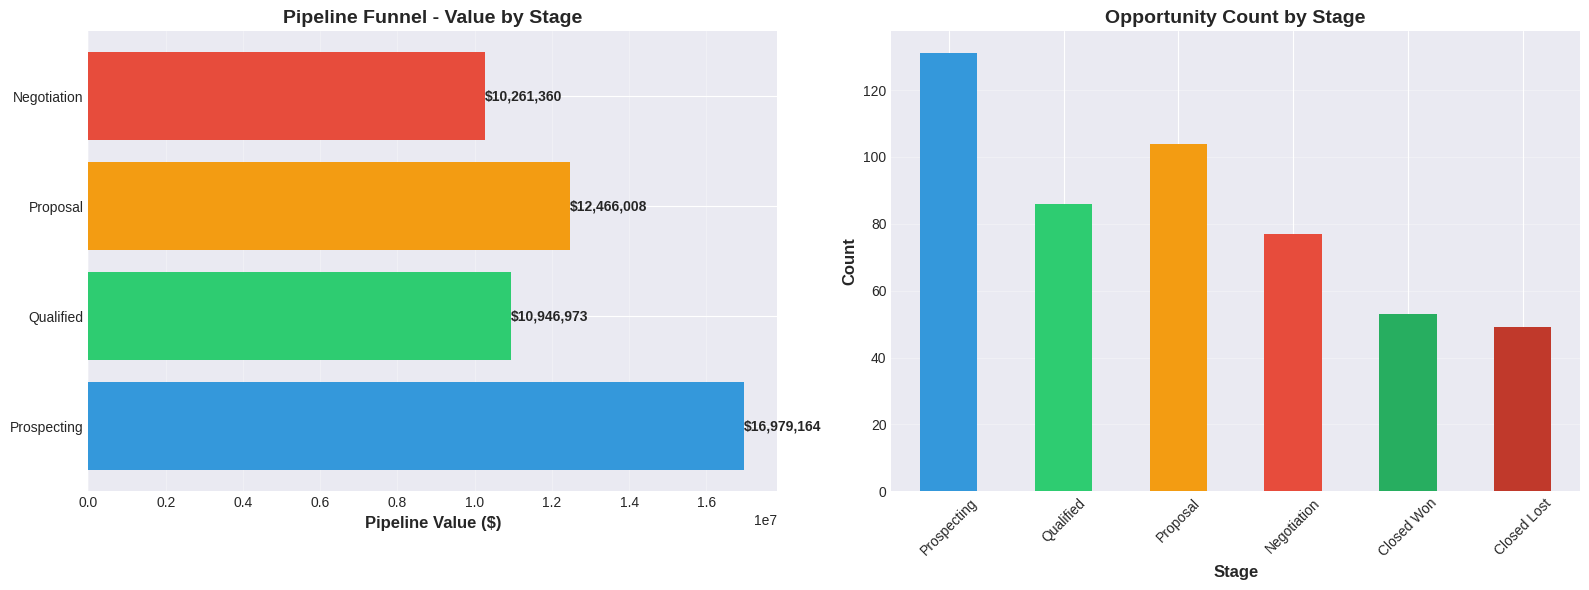

In [23]:
# Pipeline Overview - Funnel Chart
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Funnel chart - Pipeline value by stage
stage_order_active = ['Prospecting', 'Qualified', 'Proposal', 'Negotiation']
stage_values = [active_df[active_df['stage'] == stage]['deal_value'].sum() for stage in stage_order_active]

ax1.barh(stage_order_active, stage_values, color=['#3498db', '#2ecc71', '#f39c12', '#e74c3c'])
ax1.set_xlabel('Pipeline Value ($)', fontsize=12, fontweight='bold')
ax1.set_title('Pipeline Funnel - Value by Stage', fontsize=14, fontweight='bold')
ax1.grid(axis='x', alpha=0.3)

# Add value labels
for i, (stage, value) in enumerate(zip(stage_order_active, stage_values)):
    ax1.text(value, i, f'${value:,.0f}', va='center', ha='left', fontweight='bold', fontsize=10)

# Stage distribution - Count
stage_counts_viz = df_clean['stage'].value_counts().reindex(stage_order)
stage_counts_viz.plot(kind='bar', ax=ax2, color=['#3498db', '#2ecc71', '#f39c12', '#e74c3c', '#27ae60', '#c0392b'])
ax2.set_xlabel('Stage', fontsize=12, fontweight='bold')
ax2.set_ylabel('Count', fontsize=12, fontweight='bold')
ax2.set_title('Opportunity Count by Stage', fontsize=14, fontweight='bold')
ax2.tick_params(axis='x', rotation=45)
ax2.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()


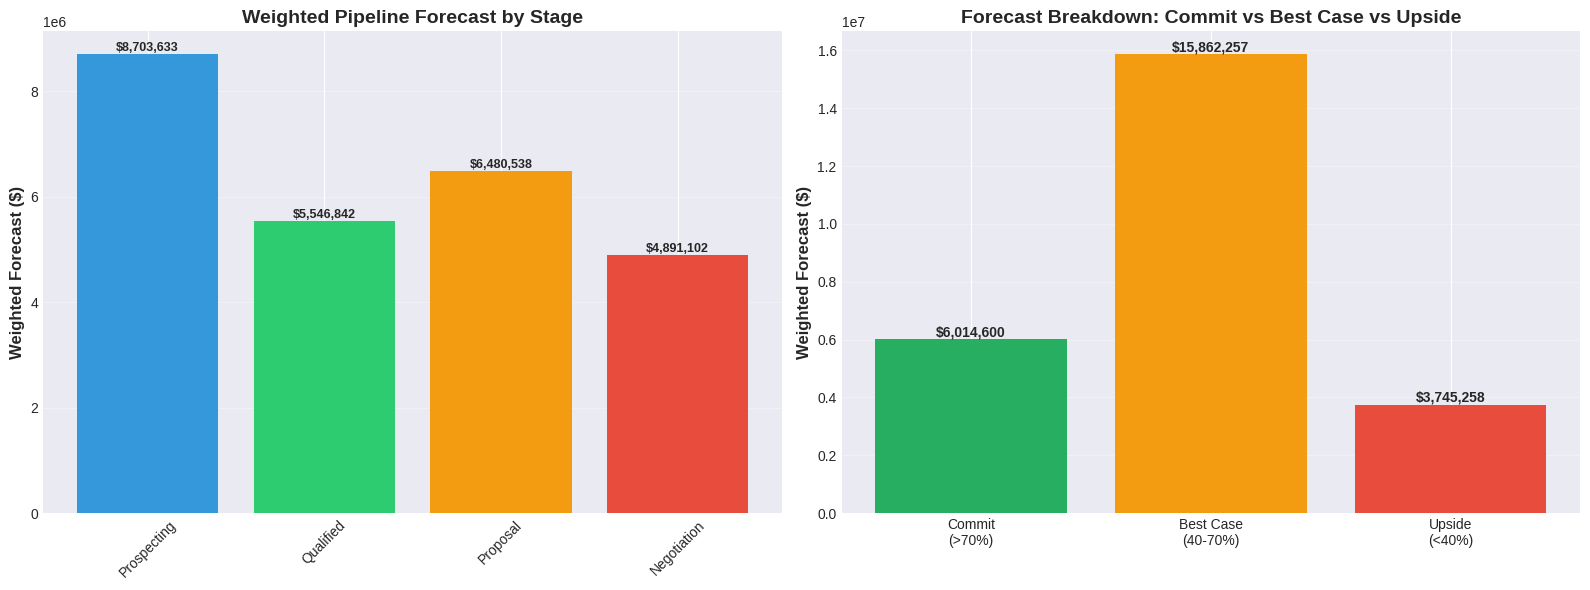

In [24]:
# Forecasting Visualizations
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Weighted pipeline by stage
forecast_stage_values = forecast_by_stage['Weighted_Forecast'].values
forecast_stage_labels = forecast_by_stage.index.tolist()

bars = ax1.bar(forecast_stage_labels, forecast_stage_values, color=['#3498db', '#2ecc71', '#f39c12', '#e74c3c'])
ax1.set_ylabel('Weighted Forecast ($)', fontsize=12, fontweight='bold')
ax1.set_title('Weighted Pipeline Forecast by Stage', fontsize=14, fontweight='bold')
ax1.tick_params(axis='x', rotation=45)
ax1.grid(axis='y', alpha=0.3)

# Add value labels on bars
for bar in bars:
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2., height,
             f'${height:,.0f}', ha='center', va='bottom', fontweight='bold', fontsize=9)

# Commit vs Forecast breakdown
forecast_categories = ['Commit\n(>70%)', 'Best Case\n(40-70%)', 'Upside\n(<40%)']
forecast_values = [commit_forecast, best_case_forecast, upside_forecast]
colors_forecast = ['#27ae60', '#f39c12', '#e74c3c']

bars2 = ax2.bar(forecast_categories, forecast_values, color=colors_forecast)
ax2.set_ylabel('Weighted Forecast ($)', fontsize=12, fontweight='bold')
ax2.set_title('Forecast Breakdown: Commit vs Best Case vs Upside', fontsize=14, fontweight='bold')
ax2.grid(axis='y', alpha=0.3)

# Add value labels
for bar in bars2:
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2., height,
             f'${height:,.0f}', ha='center', va='bottom', fontweight='bold', fontsize=10)

plt.tight_layout()
plt.show()


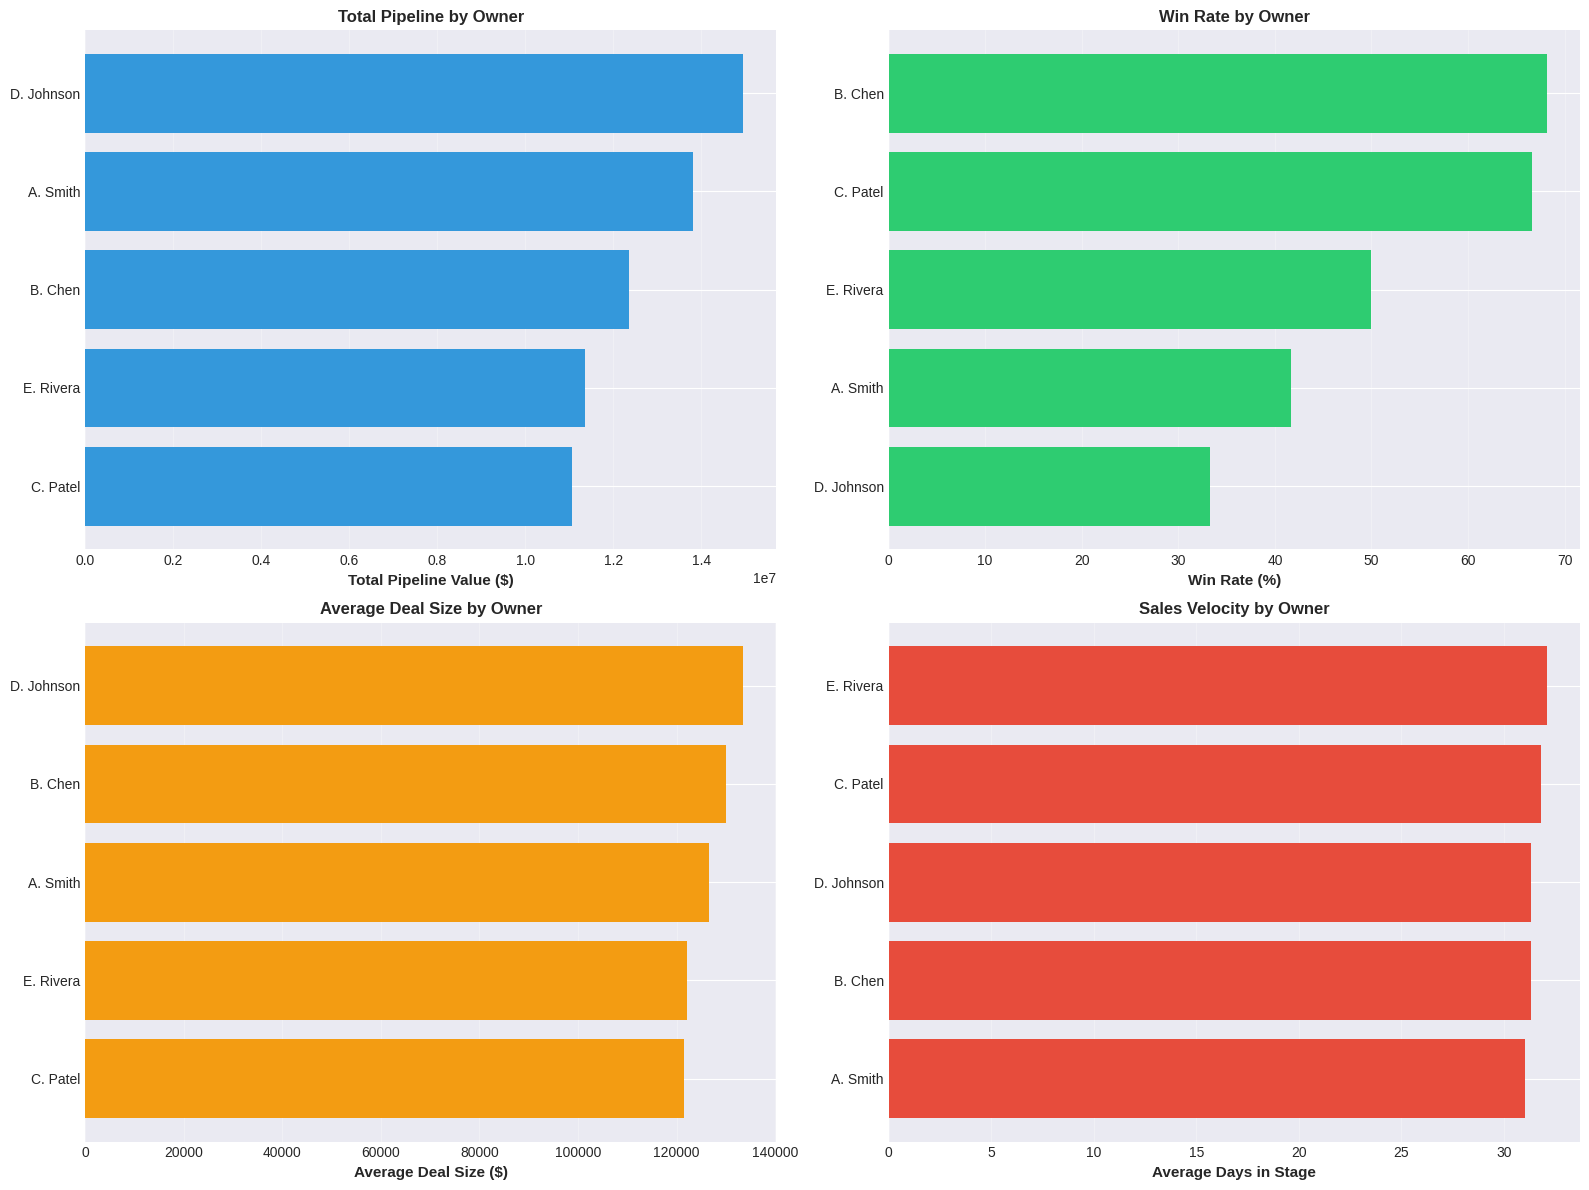

In [25]:
# Performance Visualizations - Owner Comparison
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Owner Pipeline Value
owner_pipeline = owner_performance.sort_values('Total_Pipeline', ascending=True)
axes[0, 0].barh(owner_pipeline.index, owner_pipeline['Total_Pipeline'], color='#3498db')
axes[0, 0].set_xlabel('Total Pipeline Value ($)', fontsize=11, fontweight='bold')
axes[0, 0].set_title('Total Pipeline by Owner', fontsize=12, fontweight='bold')
axes[0, 0].grid(axis='x', alpha=0.3)

# Owner Win Rate
owner_winrate = owner_performance.sort_values('Win_Rate_%', ascending=True)
axes[0, 1].barh(owner_winrate.index, owner_winrate['Win_Rate_%'], color='#2ecc71')
axes[0, 1].set_xlabel('Win Rate (%)', fontsize=11, fontweight='bold')
axes[0, 1].set_title('Win Rate by Owner', fontsize=12, fontweight='bold')
axes[0, 1].grid(axis='x', alpha=0.3)

# Owner Average Deal Size
owner_dealsize = owner_performance.sort_values('Avg_Deal_Size', ascending=True)
axes[1, 0].barh(owner_dealsize.index, owner_dealsize['Avg_Deal_Size'], color='#f39c12')
axes[1, 0].set_xlabel('Average Deal Size ($)', fontsize=11, fontweight='bold')
axes[1, 0].set_title('Average Deal Size by Owner', fontsize=12, fontweight='bold')
axes[1, 0].grid(axis='x', alpha=0.3)

# Owner Velocity
owner_velocity_viz = owner_performance.sort_values('Avg_Days_in_Stage', ascending=True)
axes[1, 1].barh(owner_velocity_viz.index, owner_velocity_viz['Avg_Days_in_Stage'], color='#e74c3c')
axes[1, 1].set_xlabel('Average Days in Stage', fontsize=11, fontweight='bold')
axes[1, 1].set_title('Sales Velocity by Owner', fontsize=12, fontweight='bold')
axes[1, 1].grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.show()


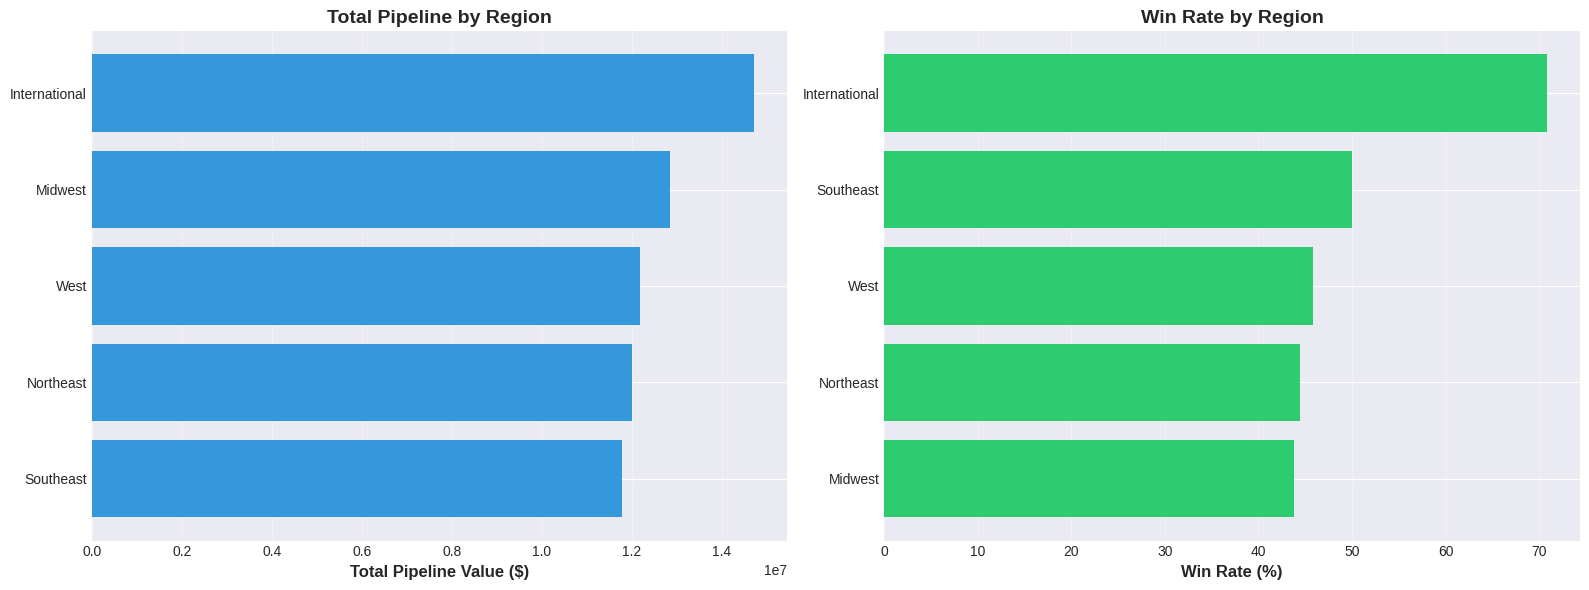

In [26]:
# Regional Performance Heatmap
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Regional Pipeline Value
region_pipeline = region_performance.sort_values('Total_Pipeline', ascending=True)
axes[0].barh(region_pipeline.index, region_pipeline['Total_Pipeline'], color='#3498db')
axes[0].set_xlabel('Total Pipeline Value ($)', fontsize=12, fontweight='bold')
axes[0].set_title('Total Pipeline by Region', fontsize=14, fontweight='bold')
axes[0].grid(axis='x', alpha=0.3)

# Regional Win Rate
region_winrate = region_performance.sort_values('Win_Rate_%', ascending=True)
axes[1].barh(region_winrate.index, region_winrate['Win_Rate_%'], color='#2ecc71')
axes[1].set_xlabel('Win Rate (%)', fontsize=12, fontweight='bold')
axes[1].set_title('Win Rate by Region', fontsize=14, fontweight='bold')
axes[1].grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.show()


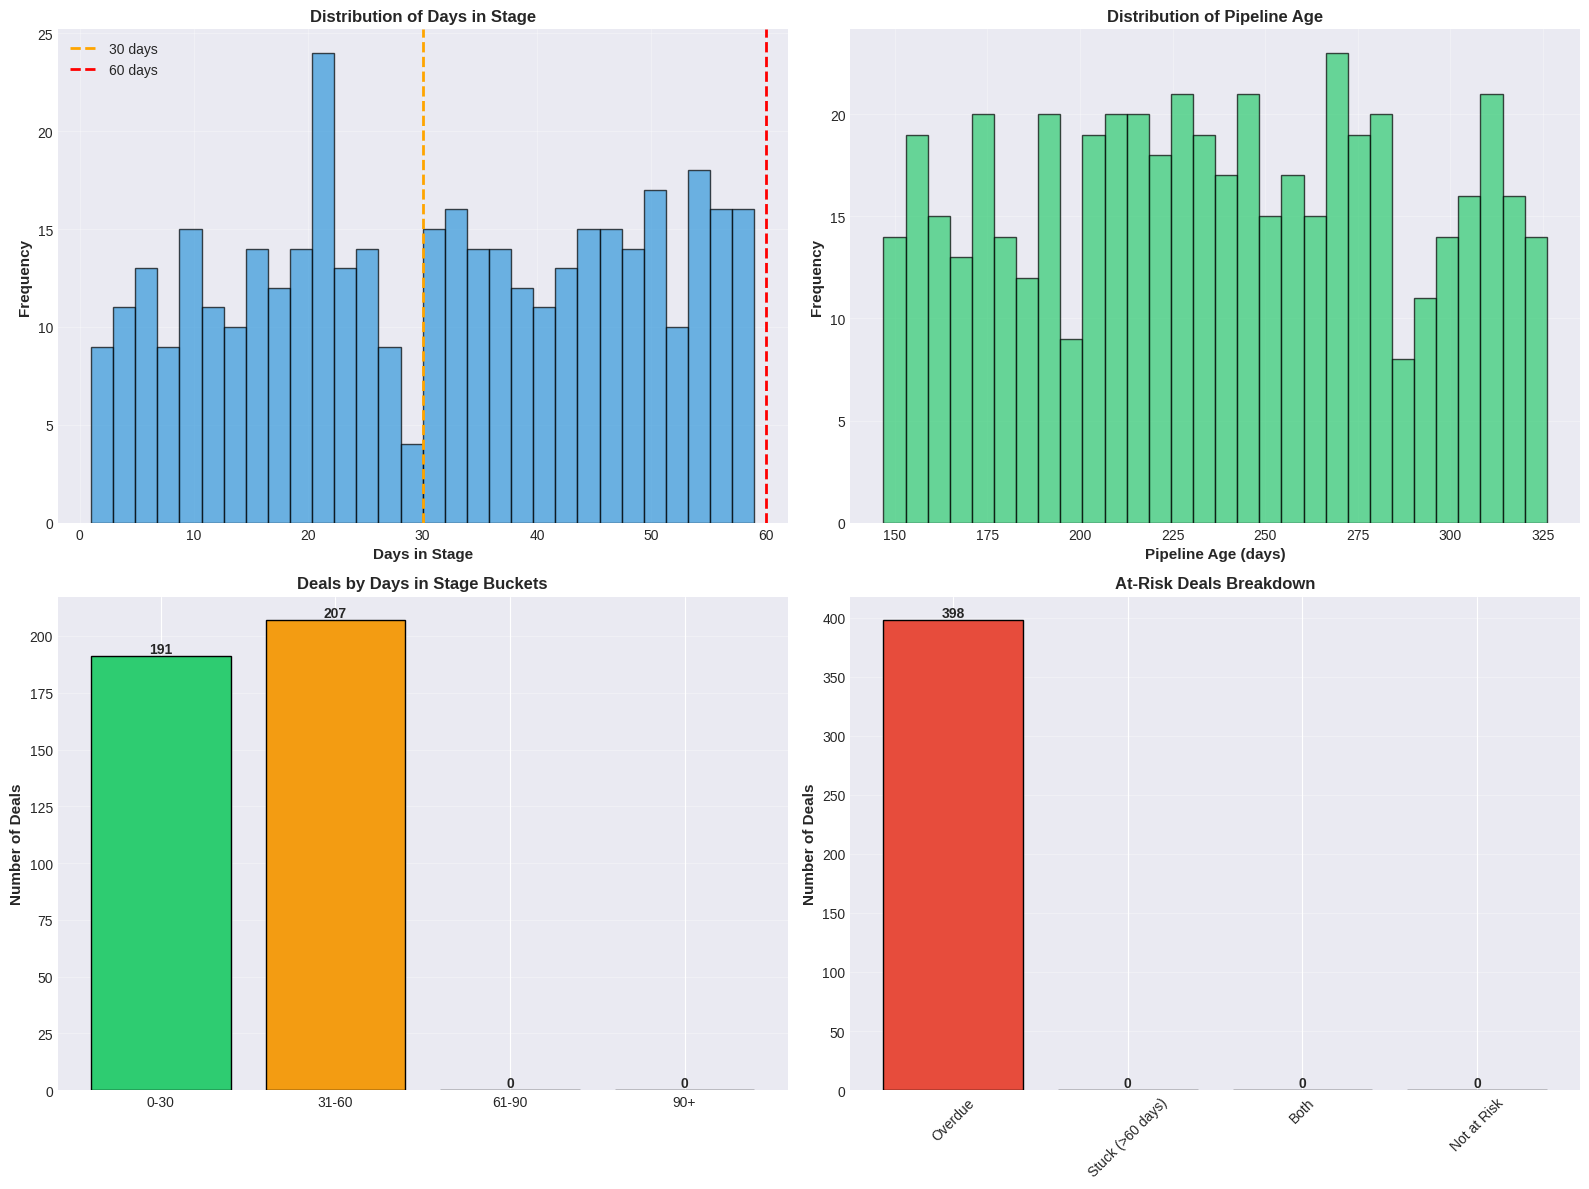

In [27]:
# Health Indicators - Aging Analysis
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Days in stage distribution
axes[0, 0].hist(active_df['days_in_stage'], bins=30, color='#3498db', edgecolor='black', alpha=0.7)
axes[0, 0].axvline(30, color='orange', linestyle='--', linewidth=2, label='30 days')
axes[0, 0].axvline(60, color='red', linestyle='--', linewidth=2, label='60 days')
axes[0, 0].set_xlabel('Days in Stage', fontsize=11, fontweight='bold')
axes[0, 0].set_ylabel('Frequency', fontsize=11, fontweight='bold')
axes[0, 0].set_title('Distribution of Days in Stage', fontsize=12, fontweight='bold')
axes[0, 0].legend()
axes[0, 0].grid(alpha=0.3)

# Pipeline age distribution
axes[0, 1].hist(df_clean['pipeline_age'].dropna(), bins=30, color='#2ecc71', edgecolor='black', alpha=0.7)
axes[0, 1].set_xlabel('Pipeline Age (days)', fontsize=11, fontweight='bold')
axes[0, 1].set_ylabel('Frequency', fontsize=11, fontweight='bold')
axes[0, 1].set_title('Distribution of Pipeline Age', fontsize=12, fontweight='bold')
axes[0, 1].grid(alpha=0.3)

# Aging buckets
aging_buckets = ['0-30', '31-60', '61-90', '90+']
aging_counts = [
    len(active_df[(active_df['days_in_stage'] >= 0) & (active_df['days_in_stage'] <= 30)]),
    len(active_df[(active_df['days_in_stage'] > 30) & (active_df['days_in_stage'] <= 60)]),
    len(active_df[(active_df['days_in_stage'] > 60) & (active_df['days_in_stage'] <= 90)]),
    len(active_df[active_df['days_in_stage'] > 90])
]
colors_aging = ['#2ecc71', '#f39c12', '#e67e22', '#e74c3c']
axes[1, 0].bar(aging_buckets, aging_counts, color=colors_aging, edgecolor='black')
axes[1, 0].set_ylabel('Number of Deals', fontsize=11, fontweight='bold')
axes[1, 0].set_title('Deals by Days in Stage Buckets', fontsize=12, fontweight='bold')
axes[1, 0].grid(axis='y', alpha=0.3)
for i, (bucket, count) in enumerate(zip(aging_buckets, aging_counts)):
    axes[1, 0].text(i, count, str(count), ha='center', va='bottom', fontweight='bold')

# At-risk deals breakdown
at_risk_breakdown = {
    'Overdue': len(active_df[active_df['is_overdue']]),
    'Stuck (>60 days)': len(active_df[active_df['is_stuck']]),
    'Both': len(active_df[active_df['is_overdue'] & active_df['is_stuck']]),
    'Not at Risk': len(active_df[~active_df['at_risk']])
}
axes[1, 1].bar(at_risk_breakdown.keys(), at_risk_breakdown.values(),
               color=['#e74c3c', '#e67e22', '#c0392b', '#2ecc71'], edgecolor='black')
axes[1, 1].set_ylabel('Number of Deals', fontsize=11, fontweight='bold')
axes[1, 1].set_title('At-Risk Deals Breakdown', fontsize=12, fontweight='bold')
axes[1, 1].tick_params(axis='x', rotation=45)
axes[1, 1].grid(axis='y', alpha=0.3)
for i, (key, value) in enumerate(at_risk_breakdown.items()):
    axes[1, 1].text(i, value, str(value), ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()


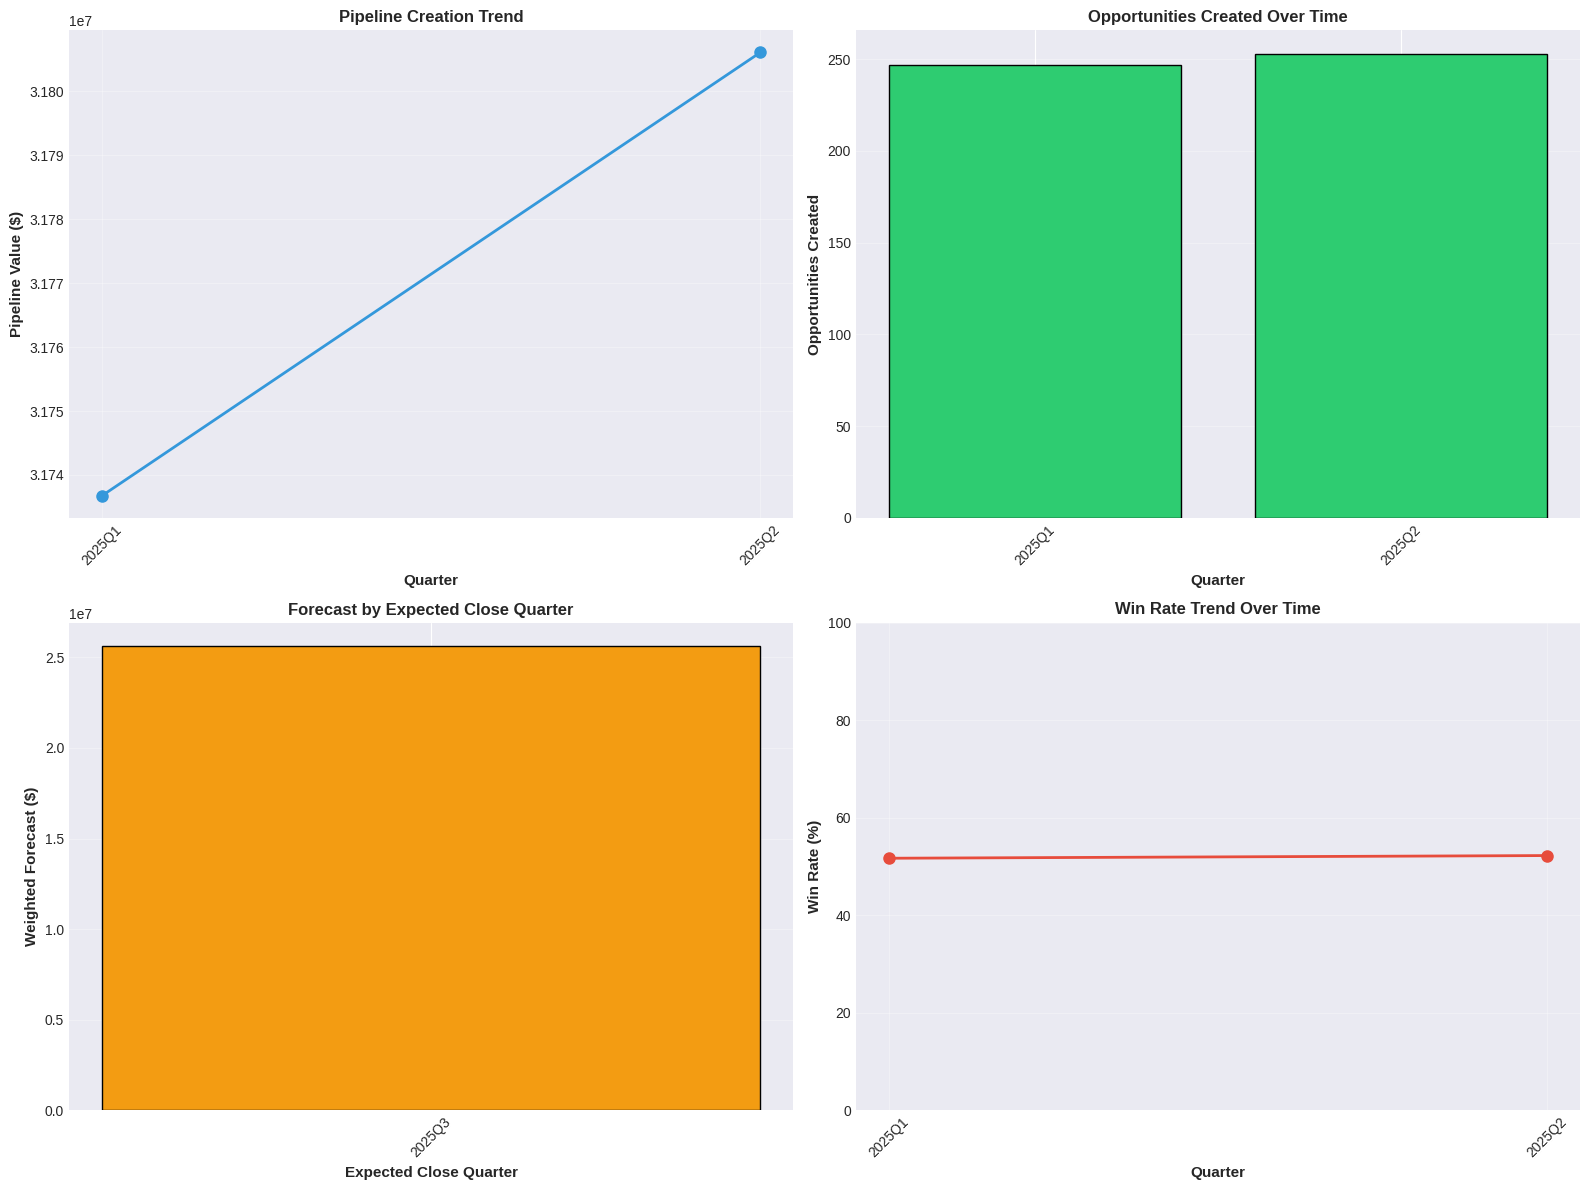

In [28]:
# Trends Over Time
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Pipeline creation trend
pipeline_created_trend.index = pipeline_created_trend.index.astype(str)
axes[0, 0].plot(pipeline_created_trend.index, pipeline_created_trend['Total_Value'],
                marker='o', linewidth=2, markersize=8, color='#3498db')
axes[0, 0].set_xlabel('Quarter', fontsize=11, fontweight='bold')
axes[0, 0].set_ylabel('Pipeline Value ($)', fontsize=11, fontweight='bold')
axes[0, 0].set_title('Pipeline Creation Trend', fontsize=12, fontweight='bold')
axes[0, 0].tick_params(axis='x', rotation=45)
axes[0, 0].grid(alpha=0.3)

# Opportunities created trend
axes[0, 1].bar(pipeline_created_trend.index, pipeline_created_trend['Opportunities_Created'],
               color='#2ecc71', edgecolor='black')
axes[0, 1].set_xlabel('Quarter', fontsize=11, fontweight='bold')
axes[0, 1].set_ylabel('Opportunities Created', fontsize=11, fontweight='bold')
axes[0, 1].set_title('Opportunities Created Over Time', fontsize=12, fontweight='bold')
axes[0, 1].tick_params(axis='x', rotation=45)
axes[0, 1].grid(axis='y', alpha=0.3)

# Forecast by quarter
forecast_by_quarter.index = forecast_by_quarter.index.astype(str)
axes[1, 0].bar(forecast_by_quarter.index, forecast_by_quarter['Weighted_Forecast'],
               color='#f39c12', edgecolor='black')
axes[1, 0].set_xlabel('Expected Close Quarter', fontsize=11, fontweight='bold')
axes[1, 0].set_ylabel('Weighted Forecast ($)', fontsize=11, fontweight='bold')
axes[1, 0].set_title('Forecast by Expected Close Quarter', fontsize=12, fontweight='bold')
axes[1, 0].tick_params(axis='x', rotation=45)
axes[1, 0].grid(axis='y', alpha=0.3)

# Win rate trends (if available)
if len(closed_by_quarter) > 0:
    closed_by_quarter.index = closed_by_quarter.index.astype(str)
    axes[1, 1].plot(closed_by_quarter.index, closed_by_quarter['Win_Rate_%'],
                    marker='o', linewidth=2, markersize=8, color='#e74c3c')
    axes[1, 1].set_xlabel('Quarter', fontsize=11, fontweight='bold')
    axes[1, 1].set_ylabel('Win Rate (%)', fontsize=11, fontweight='bold')
    axes[1, 1].set_title('Win Rate Trend Over Time', fontsize=12, fontweight='bold')
    axes[1, 1].tick_params(axis='x', rotation=45)
    axes[1, 1].grid(alpha=0.3)
    axes[1, 1].set_ylim([0, 100])
else:
    axes[1, 1].text(0.5, 0.5, 'Insufficient data\nfor win rate trend',
                    ha='center', va='center', fontsize=12)
    axes[1, 1].set_title('Win Rate Trend Over Time', fontsize=12, fontweight='bold')

plt.tight_layout()
plt.show()


## 8. QBR Insights & Recommendations


In [29]:
# Executive Summary
print("=" * 80)
print("EXECUTIVE SUMMARY - QUARTERLY BUSINESS REVIEW")
print("=" * 80)

print(f"\n KEY METRICS AT A GLANCE")
print(f"{'='*80}")
print(f"Total Active Pipeline Value:     ${total_pipeline_value:>15,.2f}")
print(f"Weighted Pipeline Forecast:      ${total_weighted_pipeline:>15,.2f}")
print(f"Active Opportunities:            {active_opportunities_count:>15,}")
print(f"Pipeline Coverage Ratio:         {total_weighted_pipeline/total_pipeline_value:>15.2%}")
print(f"Overall Win Rate:                {win_rate:>15.2%}")
print(f"Average Pipeline Age:            {overall_avg_pipeline_age:>15.1f} days")
print(f"Average Days to Close:          {overall_avg_days_to_close:>15.1f} days")

# Pipeline Health Score (composite metric)
health_score = 100
if total_weighted_pipeline/total_pipeline_value < 0.5:
    health_score -= 20
if overall_avg_days_to_close > 90:
    health_score -= 15
if active_df['at_risk'].sum() / len(active_df) > 0.2:
    health_score -= 15
if win_rate < 0.4:
    health_score -= 10

print(f"\n PIPELINE HEALTH SCORE: {max(0, health_score)}/100")
if health_score >= 80:
    health_status = "EXCELLENT"
elif health_score >= 60:
    health_status = "GOOD"
elif health_score >= 40:
    health_status = "NEEDS ATTENTION"
else:
    health_status = "CRITICAL"
print(f"Status: {health_status}")

print(f"\n FORECAST SUMMARY")
print(f"{'='*80}")
print(f"Commit Forecast (>70% prob):    ${commit_forecast:>15,.2f}")
print(f"Best Case Forecast (40-70%):     ${best_case_forecast:>15,.2f}")
print(f"Upside Forecast (<40%):         ${upside_forecast:>15,.2f}")
print(f"{''*80}")
print(f"Total Weighted Forecast:         ${commit_forecast + best_case_forecast + upside_forecast:>15,.2f}")


EXECUTIVE SUMMARY - QUARTERLY BUSINESS REVIEW

 KEY METRICS AT A GLANCE
Total Active Pipeline Value:     $  50,653,505.20
Weighted Pipeline Forecast:      $  25,622,115.65
Active Opportunities:                        398
Pipeline Coverage Ratio:                  50.58%
Overall Win Rate:                         51.96%
Average Pipeline Age:                      236.3 days
Average Days to Close:                    -99.9 days

 PIPELINE HEALTH SCORE: 85/100
Status: EXCELLENT

 FORECAST SUMMARY
Commit Forecast (>70% prob):    $   6,014,600.39
Best Case Forecast (40-70%):     $  15,862,257.32
Upside Forecast (<40%):         $   3,745,257.94

Total Weighted Forecast:         $  25,622,115.65


In [30]:
# Risk Identification
print("\n" + "=" * 80)
print("RISK IDENTIFICATION")
print("=" * 80)

at_risk_deals = active_df[active_df['at_risk']]
at_risk_value = at_risk_deals['deal_value'].sum()
at_risk_pct = (len(at_risk_deals) / len(active_df)) * 100

print(f"\n DEALS AT RISK")
print(f"   Number of at-risk deals: {len(at_risk_deals)} ({at_risk_pct:.1f}% of active pipeline)")
print(f"   At-risk deal value: ${at_risk_value:,.2f}")
print(f"   Overdue deals: {active_df['is_overdue'].sum()}")
print(f"   Stuck deals (>60 days): {active_df['is_stuck'].sum()}")

# Low-probability high-value deals
low_prob_high_value = active_df[(active_df['probability'] < 0.4) & (active_df['deal_value'] > active_df['deal_value'].quantile(0.75))]
if len(low_prob_high_value) > 0:
    print(f"\n LOW-PROBABILITY HIGH-VALUE DEALS")
    print(f"   Count: {len(low_prob_high_value)}")
    print(f"   Total value: ${low_prob_high_value['deal_value'].sum():,.2f}")
    print(f"   These deals require immediate attention to improve probability")

# Stalled opportunities
stalled = active_df[active_df['days_in_stage'] > 60]
if len(stalled) > 0:
    print(f"\n STALLED OPPORTUNITIES (>60 days in stage)")
    print(f"   Count: {len(stalled)}")
    print(f"   Total value: ${stalled['deal_value'].sum():,.2f}")
    print(f"   Top stalled stages:")
    stalled_by_stage = stalled.groupby('stage').agg({'deal_value': 'sum', 'opportunity_id': 'count'})
    stalled_by_stage = stalled_by_stage.sort_values('deal_value', ascending=False)
    for stage, row in stalled_by_stage.head(3).iterrows():
        print(f"    - {stage}: {int(row['opportunity_id'])} deals, ${row['deal_value']:,.2f}")



RISK IDENTIFICATION

 DEALS AT RISK
   Number of at-risk deals: 398 (100.0% of active pipeline)
   At-risk deal value: $50,653,505.20
   Overdue deals: 398
   Stuck deals (>60 days): 0

 LOW-PROBABILITY HIGH-VALUE DEALS
   Count: 28
   Total value: $6,194,156.67
   These deals require immediate attention to improve probability


In [31]:
# Opportunities
print("\n" + "=" * 80)
print("OPPORTUNITIES")
print("=" * 80)

# High-value deals in late stages
late_stage_deals = active_df[active_df['stage'].isin(['Proposal', 'Negotiation'])]
high_value_late = late_stage_deals[late_stage_deals['deal_value'] > late_stage_deals['deal_value'].quantile(0.75)]

print(f"\n HIGH-VALUE DEALS IN LATE STAGES")
print(f"   Count: {len(high_value_late)}")
print(f"   Total value: ${high_value_late['deal_value'].sum():,.2f}")
print(f"   Weighted forecast: ${high_value_late['weighted_pipeline'].sum():,.2f}")
print(f"   These are prime candidates for accelerated closing")

# Strong-performing owners
top_owners = owner_performance.nlargest(2, 'Total_Pipeline')
print(f"\n TOP PERFORMING OWNERS")
for owner, row in top_owners.iterrows():
    print(f"   {owner}:")
    print(f"    - Pipeline: ${row['Total_Pipeline']:,.2f}")
    print(f"    - Win Rate: {row['Win_Rate_%']:.1f}%")
    print(f"    - Avg Deal Size: ${row['Avg_Deal_Size']:,.2f}")

# Strong-performing regions
top_regions = region_performance.nlargest(2, 'Total_Pipeline')
print(f"\n TOP PERFORMING REGIONS")
for region, row in top_regions.iterrows():
    print(f"   {region}:")
    print(f"    - Pipeline: ${row['Total_Pipeline']:,.2f}")
    print(f"    - Win Rate: {row['Win_Rate_%']:.1f}%")
    print(f"    - Avg Deal Size: ${row['Avg_Deal_Size']:,.2f}")

# Conversion improvement areas
print(f"\n CONVERSION IMPROVEMENT AREAS")
stage_conversion_analysis = active_df.groupby('stage').agg({
    'deal_value': 'sum',
    'probability': 'mean',
    'days_in_stage': 'mean'
}).round(2)
for stage, row in stage_conversion_analysis.iterrows():
    if row['probability'] < 0.5 and row['days_in_stage'] > 30:
        print(f"   {stage}: Low probability ({row['probability']:.2%}) and high days in stage ({row['days_in_stage']:.0f} days)")
        print(f"    - Consider additional qualification or acceleration tactics")



OPPORTUNITIES

 HIGH-VALUE DEALS IN LATE STAGES
   Count: 45
   Total value: $9,627,916.05
   Weighted forecast: $4,768,602.31
   These are prime candidates for accelerated closing

 TOP PERFORMING OWNERS
   D. Johnson:
    - Pipeline: $14,960,178.51
    - Win Rate: 33.3%
    - Avg Deal Size: $133,573.02
   A. Smith:
    - Pipeline: $13,806,234.41
    - Win Rate: 41.7%
    - Avg Deal Size: $126,662.70

 TOP PERFORMING REGIONS
   International:
    - Pipeline: $14,723,661.01
    - Win Rate: 70.8%
    - Avg Deal Size: $132,645.59
   Midwest:
    - Pipeline: $12,840,393.24
    - Win Rate: 43.8%
    - Avg Deal Size: $129,700.94

 CONVERSION IMPROVEMENT AREAS
   Negotiation: Low probability (49.00%) and high days in stage (31 days)
    - Consider additional qualification or acceleration tactics


In [32]:
# Actionable Recommendations
print("\n" + "=" * 80)
print("ACTIONABLE RECOMMENDATIONS")
print("=" * 80)

recommendations = []

# Focus areas for sales team
print(f"\n FOCUS AREAS FOR SALES TEAM")
if len(at_risk_deals) > 0:
    print(f"  1. IMMEDIATE ACTION REQUIRED: Address {len(at_risk_deals)} at-risk deals")
    print(f"      Review overdue deals and update expected close dates")
    print(f"      Escalate stuck deals (>60 days) to management")
    recommendations.append(f"Address {len(at_risk_deals)} at-risk deals worth ${at_risk_value:,.2f}")

if len(low_prob_high_value) > 0:
    print(f"  2. PROBABILITY IMPROVEMENT: Focus on {len(low_prob_high_value)} low-probability high-value deals")
    print(f"      Provide additional resources or support")
    print(f"      Review qualification criteria")
    recommendations.append(f"Improve probability on {len(low_prob_high_value)} high-value deals")

if len(high_value_late) > 0:
    print(f"  3. ACCELERATE CLOSING: Prioritize {len(high_value_late)} high-value late-stage deals")
    print(f"      Expedite decision-making processes")
    print(f"      Provide executive sponsorship if needed")
    recommendations.append(f"Accelerate closing of {len(high_value_late)} late-stage deals worth ${high_value_late['deal_value'].sum():,.2f}")

# Pipeline gaps
print(f"\n PIPELINE GAPS TO ADDRESS")
stage_dist = active_df['stage'].value_counts()
if stage_dist.get('Prospecting', 0) < stage_dist.get('Qualified', 0):
    print(f"   Prospecting pipeline is thin - focus on lead generation")
    recommendations.append("Increase prospecting activities to build pipeline")
if stage_dist.get('Negotiation', 0) < stage_dist.get('Proposal', 0) * 0.5:
    print(f"   Low conversion from Proposal to Negotiation - review proposal process")
    recommendations.append("Improve Proposal to Negotiation conversion rate")

# Forecast adjustments
print(f"\n FORECAST ADJUSTMENTS NEEDED")
if commit_forecast < total_weighted_pipeline * 0.4:
    print(f"   Commit forecast is low relative to total weighted pipeline")
    print(f"   Consider increasing probability on high-value deals")
    recommendations.append("Increase commit forecast by improving probability on key deals")

if overall_avg_days_to_close > 90:
    print(f"   Average days to close is high ({overall_avg_days_to_close:.0f} days)")
    print(f"   Review sales process efficiency")
    recommendations.append(f"Reduce sales cycle time from {overall_avg_days_to_close:.0f} days")

# Summary of recommendations
print(f"\n SUMMARY OF KEY RECOMMENDATIONS")
for i, rec in enumerate(recommendations[:5], 1):
    print(f"  {i}. {rec}")



ACTIONABLE RECOMMENDATIONS

 FOCUS AREAS FOR SALES TEAM
  1. IMMEDIATE ACTION REQUIRED: Address 398 at-risk deals
      Review overdue deals and update expected close dates
      Escalate stuck deals (>60 days) to management
  2. PROBABILITY IMPROVEMENT: Focus on 28 low-probability high-value deals
      Provide additional resources or support
      Review qualification criteria
  3. ACCELERATE CLOSING: Prioritize 45 high-value late-stage deals
      Expedite decision-making processes
      Provide executive sponsorship if needed

 PIPELINE GAPS TO ADDRESS

 FORECAST ADJUSTMENTS NEEDED
   Commit forecast is low relative to total weighted pipeline
   Consider increasing probability on high-value deals

 SUMMARY OF KEY RECOMMENDATIONS
  1. Address 398 at-risk deals worth $50,653,505.20
  2. Improve probability on 28 high-value deals
  3. Accelerate closing of 45 late-stage deals worth $9,627,916.05
  4. Increase commit forecast by improving probability on key deals


## 9. Export & Summary Tables


In [33]:
# Create summary DataFrames for key metrics
print("=" * 80)
print("SUMMARY TABLES FOR EXPORT")
print("=" * 80)

# Key Metrics Summary
key_metrics_summary = pd.DataFrame({
    'Metric': [
        'Total Pipeline Value',
        'Weighted Pipeline',
        'Active Opportunities',
        'Pipeline Coverage Ratio',
        'Overall Win Rate',
        'Average Pipeline Age (days)',
        'Average Days to Close',
        'At-Risk Deals Count',
        'At-Risk Deal Value',
        'Commit Forecast',
        'Best Case Forecast',
        'Upside Forecast'
    ],
    'Value': [
        f"${total_pipeline_value:,.2f}",
        f"${total_weighted_pipeline:,.2f}",
        f"{active_opportunities_count:,}",
        f"{total_weighted_pipeline/total_pipeline_value:.2%}",
        f"{win_rate:.2%}",
        f"{overall_avg_pipeline_age:.1f}",
        f"{overall_avg_days_to_close:.1f}",
        f"{active_df['at_risk'].sum():,}",
        f"${active_df[active_df['at_risk']]['deal_value'].sum():,.2f}",
        f"${commit_forecast:,.2f}",
        f"${best_case_forecast:,.2f}",
        f"${upside_forecast:,.2f}"
    ]
})

print("\n KEY METRICS SUMMARY")
print(key_metrics_summary.to_string(index=False))


SUMMARY TABLES FOR EXPORT

 KEY METRICS SUMMARY
                     Metric          Value
       Total Pipeline Value $50,653,505.20
          Weighted Pipeline $25,622,115.65
       Active Opportunities            398
    Pipeline Coverage Ratio         50.58%
           Overall Win Rate         51.96%
Average Pipeline Age (days)          236.3
      Average Days to Close          -99.9
        At-Risk Deals Count            398
         At-Risk Deal Value $50,653,505.20
            Commit Forecast  $6,014,600.39
         Best Case Forecast $15,862,257.32
            Upside Forecast  $3,745,257.94


In [34]:
# Export cleaned data (optional)
export_cleaned = False  # Set to True to export

if export_cleaned:
    df_clean.to_csv('mastercard_pipeline_cleaned.csv', index=False)
    print("\n Cleaned data exported to 'mastercard_pipeline_cleaned.csv'")
else:
    print("\n To export cleaned data, set 'export_cleaned = True' in the cell above")

# Display final summary
print("\n" + "=" * 80)
print("ANALYSIS COMPLETE")
print("=" * 80)
print(f"\nAnalysis Date: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")
print(f"Total Opportunities Analyzed: {len(df_clean):,}")
print(f"Active Pipeline Opportunities: {len(active_df):,}")
print(f"\nThis analysis is ready for Quarterly Business Review presentation.")
print("=" * 80)



 To export cleaned data, set 'export_cleaned = True' in the cell above

ANALYSIS COMPLETE

Analysis Date: 2025-11-23 03:35:57
Total Opportunities Analyzed: 500
Active Pipeline Opportunities: 398

This analysis is ready for Quarterly Business Review presentation.
